15.12.2021

# Validate U-Net predictions

Load a bunch of UNet predictions in folder `trainings_validation` and compute some metrics, plots, etc.

Predictions are saved as:
`{training_name}_{epoch}_{video_id}_{class}.tif`

**Idea**: Use predictions to produce plots and tables to visualize the results.

In [113]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
import numpy as np
import glob
import os
import imageio
from collections import defaultdict
import pprint
import json

from scipy.ndimage.morphology import binary_dilation, binary_erosion
from sklearn.metrics import jaccard_score, f1_score

import pandas as pd
import matplotlib.pyplot as plt

import unet
from metrics_tools import (correspondences_precision_recall, 
                           Metrics, 
                           reduce_metrics, 
                           empty_marginal_frames,
                           process_spark_prediction,
                           process_puff_prediction,
                           process_wave_prediction,
                           compute_puff_wave_metrics,
                           write_videos_on_disk,
                           get_sparks_locations_from_mask,
                           compute_prec_rec,
                           reduce_metrics_thresholds
                          )
from dataset_tools import load_movies_ids

In [3]:
BASEDIR = os.path.abspath('')
BASEDIR

'C:\\Users\\dotti\\sparks_project\\sparks'

# Load data

### Select predictions to load

In [115]:
training_names = [#"256_long_chunks_ubelix",
                  "focal_loss_gamma_5_ubelix"
                  ]

epoch = 100000

### Configure input/output folder (TODO: aggiungere training name nella path nelle altre sections)

In [116]:
metrics_folder = "trainings_validation"
# TODO: cambiare nelle altre fcts!!
os.makedirs(metrics_folder, exist_ok=True)

### Load annotations
open and process annotations (original version, sparks not processed)


In [117]:
from dataset_tools import load_annotations

ys_all_trainings = load_annotations(metrics_folder, mask_names="mask")

#ys_filenames = sorted(glob.glob(os.path.join(metrics_folder, "[0-9]*_video_mask.tif")))

#for f in ys_filenames:
#    video_id = os.path.split(f)[1][:2]
#    ys_all_trainings[video_id] = np.asarray(imageio.volread(f)).astype('int')

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [118]:
ys_all_trainings.keys()

dict_keys(['05', '10', '15', '20', '25', '32', '34', '40', '45'])

### Load predictions

In [119]:
ys = {} # contains annotations for each training
sparks = {} # contains sparks for each training
puffs = {} # contains puffs for each training
waves = {} # contains waves for each training

for training_name in training_names:
    data_folder = os.path.join(metrics_folder, training_name)
    print(f"Processing training name {training_name}...")
    print()
    # Import .tif files as numpy array
    base_name = os.path.join(data_folder,training_name+"_"+str(epoch)+"_")
    
    if training_name == "temporal_reduction": # need to use annotations from another training
        if training_names[-1] != "temporal_reduction":
            base_name_ys = os.path.join(data_folder,training_names[-1]+"_"+str(epoch)+"_")
            ys_filenames = sorted(glob.glob(base_name_ys+"[0-9][0-9]_video_ys.tif"))
        else:
            print("SELECT TRAINING NAME DIFFERENT FROM temporal_reduction")
            break
    else:    
        ys_filenames = sorted(glob.glob(base_name+"*_ys.tif"))
        
    sparks_filenames = sorted(glob.glob(base_name+"[0-9][0-9]_video_sparks.tif"))
    puffs_filenames = sorted(glob.glob(base_name+"[0-9][0-9]_video_puffs.tif"))
    waves_filenames = sorted(glob.glob(base_name+"[0-9][0-9]_video_waves.tif"))
        
    training_ys = {}
    training_sparks = {}
    training_puffs = {}
    training_waves = {}
    
    for idx,y,s,p,w in zip(ys_all_trainings.keys(),ys_filenames,sparks_filenames,puffs_filenames,waves_filenames):
        #print(f"\tProcessing the following files for movie {idx}:")
        #print(f"\tAnnotations filename: {y}")
        #print(f"\tSparks filename: {s}")
        #print(f"\tPuffs filename: {p}")
        #print(f"\tWaves filename: {w}\t")
        #print()
        ys_loaded = np.asarray(imageio.volread(y)).astype('int')
        training_ys[idx] = ys_loaded
        
        if training_name == "temporal_reduction": # repeat each frame 4 times
            s_preds = np.asarray(imageio.volread(s))
            p_preds = np.asarray(imageio.volread(p))
            w_preds = np.asarray(imageio.volread(w))
                        
            # repeat predicted frames x4
            s_preds = np.repeat(s_preds,4,0)
            p_preds = np.repeat(p_preds,4,0)
            w_preds = np.repeat(w_preds,4,0)
            
            # if original length %4 != 0, crop preds
            if ys_loaded.shape != s_preds.shape:
                duration = ys_loaded.shape[0]
                s_preds = s_preds[:duration]
                p_preds = p_preds[:duration]
                w_preds = w_preds[:duration]
            
            assert ys_loaded.shape == s_preds.shape
            assert ys_loaded.shape == p_preds.shape
            assert ys_loaded.shape == w_preds.shape
            
            training_sparks[idx] = s_preds
            training_puffs[idx] = p_preds
            training_waves[idx] = w_preds
        else:
            training_sparks[idx] = np.asarray(imageio.volread(s))
            training_puffs[idx] = np.asarray(imageio.volread(p))
            training_waves[idx] = np.asarray(imageio.volread(w))

    ys[training_name] = training_ys
    sparks[training_name] = training_sparks
    puffs[training_name] = training_puffs
    waves[training_name] = training_waves       

Processing training name focal_loss_gamma_5_ubelix...



### Load original movies

In [120]:
# NEW
movie_names = ys_all_trainings.keys()
movie_path = os.path.join("..","data","raw_data_and_processing","original_movies")
movies = load_movies_ids(movie_path, movie_names)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


# Jaccard index (IoU score) for puffs and waves
12.05.2021
Seguendo il consiglio di Pablo:
erosion & dilation delle annotations -> creazione di una exclusion region che viene ignorata dal supporto del Jaccard index

## Compute metrics for sample video

In [121]:
# results for a sample movie in sample dataset
name = "focal_loss_gamma_5_ubelix"
idx = '05'

In [17]:
# parameters
ignore_frames = 6

t_detection = 0.5
min_radius_puffs = 4
min_radius_waves = 10

### Get binary preds and remove ignored frames

In [18]:
# get predictions
sparks_sample = sparks[name][idx]
puffs_sample = puffs[name][idx]
waves_sample = waves[name][idx]

In [19]:
puffs_binary = process_puff_prediction(puffs_sample, 
                                       t_detection, 
                                       min_radius_puffs, 
                                       ignore_frames)

waves_binary = process_wave_prediction(waves_sample, 
                                       t_detection, 
                                       min_radius_waves, 
                                       ignore_frames)

### Get binary ys and remove ignored frames

In [ ]:
# get binary ys
ys_sample = ys_all_trainings[idx]

ys_puffs_sample = np.where(ys_sample==3,1,0)
ys_waves_sample = np.where(ys_sample==2,1,0)
ignore_mask = np.where(ys_sample==4,1,0)

In [ ]:
ys_puffs_sample = empty_marginal_frames(ys_puffs_sample, ignore_frames)
ys_waves_sample = empty_marginal_frames(ys_waves_sample, ignore_frames)
ignore_mask = empty_marginal_frames(ignore_mask, ignore_frames)

### Plot a sample frame

In [ ]:
sparks_sample.shape, puffs_sample.shape, waves_sample.shape, ys_sample.shape

In [ ]:
sample_frame = 199 # 346

In [ ]:
# Plot annotations and preds of sample frame

#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,8))
plt.suptitle(f"Annotations and preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(4,2,1)
ax.set_title("Puffs annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(4,2,2)
ax.set_title("Waves annotations")
plt.imshow(ys_waves_sample[sample_frame])

ax = plt.subplot(4,2,3)
ax.set_title("Puffs binary preds")
plt.imshow(puffs_binary[sample_frame])

ax = plt.subplot(4,2,4)
ax.set_title("Waves binary preds")
plt.imshow(waves_binary[sample_frame])

ax = plt.subplot(4,2,5)
ax.set_title("Puffs original preds")
plt.imshow(puffs_sample[sample_frame])

ax = plt.subplot(4,2,6)
ax.set_title("Waves original preds")
plt.imshow(waves_sample[sample_frame])

ax = plt.subplot(4,2,7)
ax.set_title("Ignore mask (annotations)")
plt.imshow(ignore_mask[sample_frame])


plt.show()

### Save sample binary preds on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_puffs.tif"), np.uint8(puffs_binary))
imageio.volwrite(os.path.join(metrics_folder, "binary_preds_waves.tif"), np.uint8(waves_binary))

### Save sample annotations on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "annotations_puffs.tif"), np.uint8(ys_puffs_sample))
imageio.volwrite(os.path.join(metrics_folder, "annotations_waves.tif"), np.uint8(ys_waves_sample))

### Save ignore mask on disk

In [ ]:
imageio.volwrite(os.path.join(metrics_folder, "ignore_mask.tif"), np.uint8(ignore_mask))

### Compute Jaccard score (without exclusion zone)

In [21]:
iou_puffs = jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())
iou_waves = jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())

print(f"Jaccard score puffs: {iou_puffs}")
print(f"Jaccard score waves: {iou_waves}")

Jaccard score puffs: 0.16206809118779245
Jaccard score waves: 0.0


C:\Users\dotti\.conda\envs\sparks\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
# Compute exclusion zone

exclusion_radius = 2

In [23]:
# Just for puffs
puffs_eroded = binary_erosion(ys_puffs_sample, iterations=exclusion_radius)
puffs_dilated = binary_dilation(ys_puffs_sample, iterations=exclusion_radius)

exclusion_mask = 1 - np.logical_xor(puffs_eroded, puffs_dilated)
# 1 where Jaccard index has to be computed, 0 otherwise

In [24]:
# Compute dilation for ignore mask
ignore_mask_dilated = binary_dilation(ignore_mask, iterations=exclusion_radius)

# Ignore regions in ignore mask too
exclusion_mask_ignore_roi = np.logical_and(1 - ignore_mask_dilated, exclusion_mask)

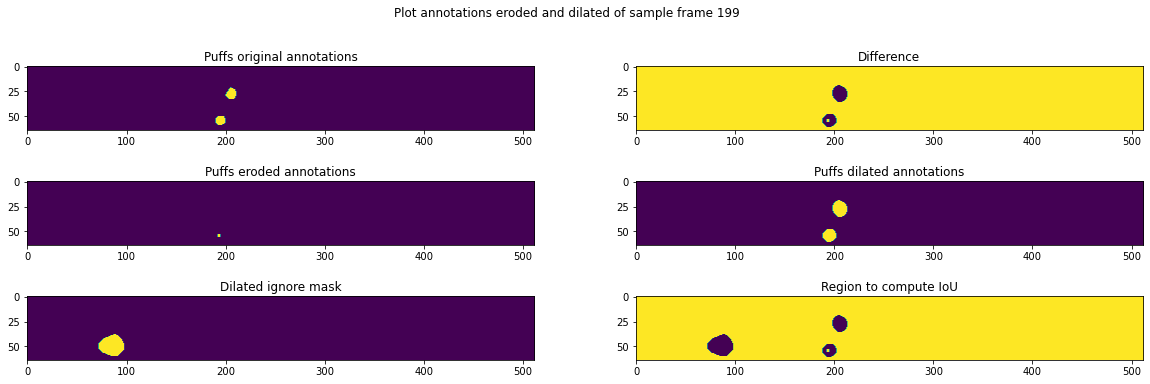

In [25]:
# Plot annotations eroded and dilated
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Plot annotations eroded and dilated of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Puffs original annotations")
plt.imshow(ys_puffs_sample[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Difference")
plt.imshow(exclusion_mask[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Puffs eroded annotations")
plt.imshow(puffs_eroded[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Puffs dilated annotations")
plt.imshow(puffs_dilated[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Dilated ignore mask")
plt.imshow(ignore_mask_dilated[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Region to compute IoU")
plt.imshow(exclusion_mask_ignore_roi[sample_frame])


plt.show()

In [26]:
# Compute intersection and union of annotations with preds

intersection = np.logical_and(ys_puffs_sample, puffs_binary)
union = np.logical_or(ys_puffs_sample, puffs_binary)

# Compute intersection and union only in exclusion mask

intersection_mask = np.logical_and(intersection, exclusion_mask_ignore_roi)
union_mask = np.logical_and(union, exclusion_mask_ignore_roi)

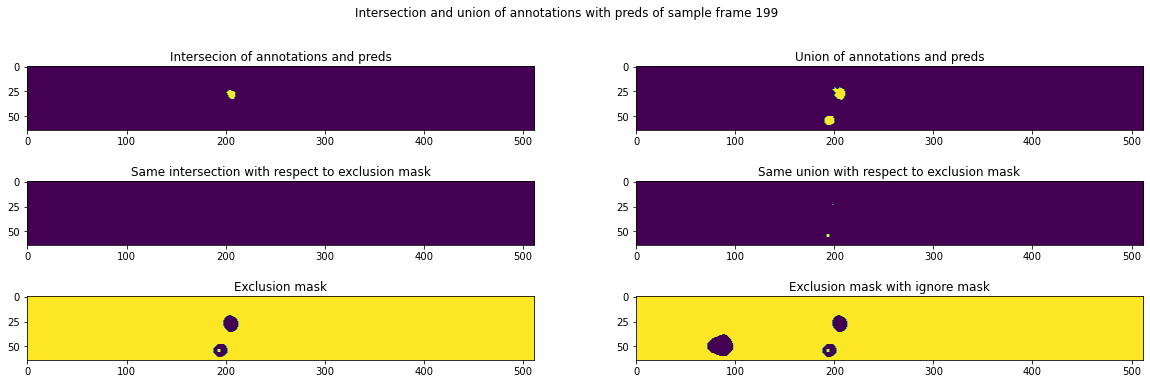

In [27]:
# Plot intersection and union
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,6))
plt.suptitle(f"Intersection and union of annotations with preds of sample frame {sample_frame}", fontsize=12)


ax = plt.subplot(3,2,1)
ax.set_title("Intersecion of annotations and preds")
plt.imshow(intersection[sample_frame])

ax = plt.subplot(3,2,2)
ax.set_title("Union of annotations and preds")
plt.imshow(union[sample_frame])

ax = plt.subplot(3,2,3)
ax.set_title("Same intersection with respect to exclusion mask")
plt.imshow(intersection_mask[sample_frame])

ax = plt.subplot(3,2,4)
ax.set_title("Same union with respect to exclusion mask")
plt.imshow(union_mask[sample_frame])

ax = plt.subplot(3,2,5)
ax.set_title("Exclusion mask")
plt.imshow(exclusion_mask[sample_frame])

ax = plt.subplot(3,2,6)
ax.set_title("Exclusion mask with ignore mask")
plt.imshow(exclusion_mask_ignore_roi[sample_frame])


plt.show()

In [28]:
# Compute Jaccard index

print(f"Pixels in intersection: {np.count_nonzero(intersection_mask)}")
print(f"Pixels in union: {np.count_nonzero(union_mask)}")

new_iou_puffs = np.count_nonzero(intersection_mask)/np.count_nonzero(union_mask)

print(f"IoU wrt to wave class: {new_iou_puffs}")

Pixels in intersection: 16943
Pixels in union: 136282
IoU wrt to wave class: 0.12432309475939596


In [29]:
new_iou_puffs = jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, exclusion_radius, ignore_mask)
new_iou_waves = jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, exclusion_radius, ignore_mask)

In [30]:
print(new_iou_puffs)
print(new_iou_waves)

0.12432309475939596
1.0


### Jaccard index for sparks

In [73]:
# get sparks annotations
ys_sparks_sample = np.where(ys_sample==1,1,0)

# get sparks predictions
t_detection_sparks = 0.9
min_radius_sparks = 3
sparks_binary = (process_spark_prediction(sparks_sample, 
                                          t_detection=t_detection_sparks,
                                          min_radius=min_radius_sparks,
                                          ignore_frames=ignore_frames,
                                          return_clean_pred=True)) != 0 

### Comparison with original implementation (when radius = 0)

In [76]:
print("Jaccard index with new method:")
print(f"Puffs: {jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, 0)}") # ! not considering ignore mask
print(f"Waves: {jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, 0)}") # ! not considering ignore mask
print(f"Sparks: {jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, 0, sparks=True)}") # ! not considering ignore mask
print()
print("Jaccard index with sklearn metrics method")
print(f"Puffs: {jaccard_score(ys_puffs_sample.ravel(), puffs_binary.ravel())}")
print(f"Waves: {jaccard_score(ys_waves_sample.ravel(), waves_binary.ravel())}")
print(f"Sparks: {jaccard_score(ys_sparks_sample.ravel(), sparks_binary.ravel())}")

Jaccard index with new method:
Puffs: 0.20890103174317864
Waves: 1.0
Sparks: 0.04723618090452261

Jaccard index with sklearn metrics method
Puffs: 0.20890103174317864
Waves: 0.0
Sparks: 0.04723618090452261


### Plot IoU with respect to different exclusion radius

In [77]:
exclusion_radius_list = [0,1,2,3,4,5,6,7,8,9,10]

# puffs
ious_puffs = []
for radius in exclusion_radius_list:
    ious_puffs.append(jaccard_score_exclusion_zone(ys_puffs_sample, puffs_binary, radius)) # ! not considering ignore mask
    
# waves
ious_waves = []
for radius in exclusion_radius_list:
    ious_waves.append(jaccard_score_exclusion_zone(ys_waves_sample, waves_binary, radius)) # ! not considering ignore mask
    
# sparks
ious_sparks = []
for radius in exclusion_radius_list:
    ious_sparks.append(jaccard_score_exclusion_zone(ys_sparks_sample, sparks_binary, radius, sparks=True)) # ! not considering ignore mask

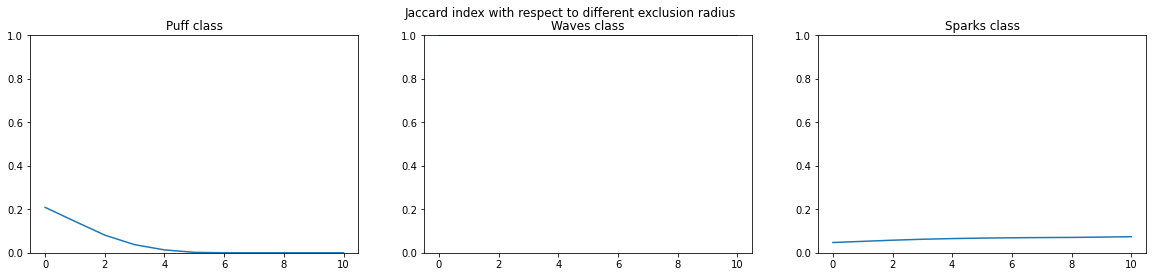

In [78]:
# Plot Jaccard index wrt different exclusion radius
#plt.rcParams.update({'font.size': 8})

plt.figure(figsize=(20,4))
plt.suptitle(f"Jaccard index with respect to different exclusion radius", fontsize=12)


ax = plt.subplot(1,3,1)
ax.set_title("Puff class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_puffs)

ax = plt.subplot(1,3,2)
ax.set_title("Waves class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_waves)

ax = plt.subplot(1,3,3)
ax.set_title("Sparks class")
plt.ylim([0, 1])
plt.plot(exclusion_radius_list, ious_sparks)


plt.show()

In [79]:
print(f"IoUs puffs: {ious_puffs}")
print(f"IoUs puffs: {ious_waves}")
print(f"IoUs puffs: {ious_sparks}")

IoUs puffs: [0.20890103174317864, 0.14459408432976714, 0.08126801152737752, 0.037353441136730156, 0.013306755737528283, 0.0021321961620469083, 7.474400179385604e-05, 0.0, 0.0, 0.0, 0.0]
IoUs puffs: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
IoUs puffs: [0.04723618090452261, 0.05264336917562724, 0.05791030064070971, 0.06230116648992577, 0.06536856745479833, 0.06762589928057554, 0.06909732431637754, 0.07004470938897168, 0.07078313253012049, 0.07219662058371736, 0.07413249211356467]


## Evaluate all trainings on all videos (plain version using exclusion radius)

Remarks: 
- IoU not computed for sparks (it doesn't make sense)

In [9]:
# params best for focal_loss_gamma_5_ubelix

# parameters
ignore_frames = 6

# sparks params
#t_detection_sparks = 0.7
#min_radius_sparks = 2

# puffs and waves params
t_detection = [0.5]#,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
min_radius = [0]#,1,2,3,4,5,6,7,8,9,10]

exclusion_radius = [0]#,1,2,3,4,5,6,7,8,9,10]

In [193]:
# each dictionary contains, for every training name, a list of IoU scores for all videos for all exclusion radius
ious_puffs_all_models = {}
ious_waves_all_models = {}

for training_name in training_names:
    print(training_name)
    # get predictions
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    # init empty dictionaires
    ious_puffs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    ious_waves = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
    for video_id in ys_all_trainings.keys():
        print("\tVideo name:", video_id)
        ys_sample = ys_all_trainings[video_id]
        puffs_sample = puffs_training[video_id]
        waves_sample = waves_training[video_id]
        
        # get ignore mask (events labelled with 4)
        ignore_mask = empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        for t in t_detection:
            print("\t\tDetection threshold:", t)
            for min_r in min_radius:
                print("\t\t\tMinimal radius:", min_r)
                # get binary predictions and remove ignored frames
                puffs_binary = process_puff_prediction(pred=puffs_sample, 
                                                       t_detection=t, 
                                                       min_radius=min_r, 
                                                       ignore_frames=ignore_frames)
                waves_binary = process_wave_prediction(waves_sample, 
                                                       t_detection=t, 
                                                       min_radius=min_r, 
                                                       ignore_frames=ignore_frames)

                # get binary ys and remove ignored frames
                ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
                ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)

                # compute IoU for some exclusion radius values
                
                for exclusion_r in exclusion_radius:
                    print("\t\t\t\tExclusion radius:", exclusion_r)
                    # puffs
                    ious_puffs[t][min_r][exclusion_r][video_id] = jaccard_score_exclusion_zone(ys=ys_puffs_sample,
                                                                                               preds=puffs_binary,
                                                                                               exclusion_radius=exclusion_r,
                                                                                               ignore_mask=ignore_mask)

                    # waves
                    ious_waves[t][min_r][exclusion_r][video_id] = jaccard_score_exclusion_zone(ys=ys_waves_sample,
                                                                                               preds=waves_binary,
                                                                                               exclusion_radius=exclusion_r,
                                                                                               ignore_mask=ignore_mask)
    
    ious_puffs_all_models_average[training_name] = ious_puffs_average
    ious_waves_all_models_average[training_name] = ious_waves_average

focal_loss_gamma_5_ubelix
	Video name: 05
		Detection threshold: 0.5
			Minimal radius: 0
				Exclusion radius: 0
				Exclusion radius: 1
				Exclusion radius: 2
				Exclusion radius: 3
				Exclusion radius: 4
				Exclusion radius: 5
				Exclusion radius: 6
				Exclusion radius: 7
				Exclusion radius: 8
				Exclusion radius: 9
				Exclusion radius: 10
			Minimal radius: 1
				Exclusion radius: 0
				Exclusion radius: 1
				Exclusion radius: 2
				Exclusion radius: 3
				Exclusion radius: 4
				Exclusion radius: 5
				Exclusion radius: 6
				Exclusion radius: 7
				Exclusion radius: 8
				Exclusion radius: 9
				Exclusion radius: 10
			Minimal radius: 2
				Exclusion radius: 0
				Exclusion radius: 1
				Exclusion radius: 2
				Exclusion radius: 3
				Exclusion radius: 4
				Exclusion radius: 5
				Exclusion radius: 6
				Exclusion radius: 7
				Exclusion radius: 8


KeyboardInterrupt: 

In [ ]:
# compute average over movies
ious_puffs_all_models_average = {}
ious_waves_all_models_average = {}

for training_name in training_names:
    ious_puffs_average = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    ious_waves_average = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    
    for t in t_detection:
        for min_r in min_radius:
            for exclusion_r in exclusion_radius:
                # compute average over all movies
                ious_puffs = ious_puffs_all_models[training_name]
                ious_waves = ious_waves_all_models[training_name]                
                ious_puffs_average[t][min_r][exclusion_r] = sum(ious_puffs[t][min_r][exclusion_r].values()) / len(ious_puffs[t][min_r][exclusion_r])
                ious_waves_average[t][min_r][exclusion_r] = sum(ious_waves[t][min_r][exclusion_r].values()) / len(ious_waves[t][min_r][exclusion_r])
                
    ious_puffs_all_models_average[training_name] = ious_puffs_average
    ious_waves_all_models_average[training_name] = ious_waves_average


In [ ]:
# save ious dictionaires on disk as json
training_name = "focal_loss_gamma_5_ubelix"
data_folder = os.path.join(metrics_folder, training_name, "puff_wave_ious")
os.makedirs(data_folder, exist_ok=True)

In [ ]:
with open(os.path.join(data_folder,"ious_puffs.json"),"w") as f:
    json.dump(ious_puffs_all_models[training_name],f)
    
with open(os.path.join(data_folder,"ious_puffs_average.json"),"w") as f:
    json.dump(ious_puffs_all_models_average[training_name],f)
    
with open(os.path.join(data_folder,"ious_waves.json"),"w") as f:
    json.dump(ious_waves_all_models[training_name],f)
    
with open(os.path.join(data_folder,"ious_waves_average.json"),"w") as f:
    json.dump(ious_waves_all_models_average[training_name],f)

### Load saved ious dictionaires from .json files

### Confusion matrix wrt to varying min size and detection threshold

In [44]:
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt

In [45]:
# fix training name
training_name = "focal_loss_gamma_5_ubelix"

In [47]:
# fix exclusion radius to zero
exclusion_r = 0

# get dicts for fixed exclusion radius
dict_cmatrix_puffs = {t: {r: iou[0] for (r, iou) in iou_min_radius.items()} for (t, iou_min_radius) in ious_puffs_all_models_average[training_name].items()}
dict_cmatrix_waves = {t: {r: iou[0] for (r, iou) in iou_min_radius.items()} for (t, iou_min_radius) in ious_waves_all_models_average[training_name].items()}

In [49]:
df_puffs = pd.DataFrame.from_dict(dict_cmatrix_puffs)
df_waves = pd.DataFrame.from_dict(dict_cmatrix_waves)

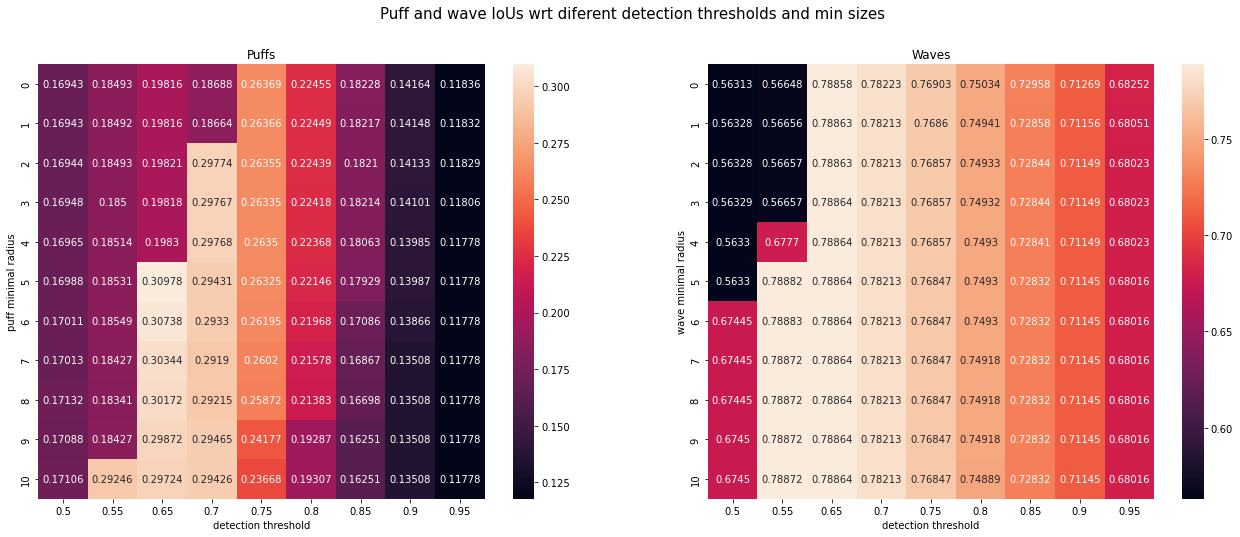

In [203]:
plt.figure(figsize=(22,8))
plt.suptitle(f"Puff and wave IoUs wrt diferent detection thresholds and min sizes", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Puffs")
sns.heatmap(df_puffs, annot=True, fmt='.5g')
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Waves")
sns.heatmap(df_waves, annot=True, fmt='.5g')
ax.set_xlabel("detection threshold")
ax.set_ylabel("wave minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_IoU_all_movies.jpg"))
plt.show()

### Plot average IoU wrt to exclusion radius (for average and all single movies)

In [52]:
# fix a training name
training_name = "focal_loss_gamma_5_ubelix"

In [53]:
# fix best detection threshold and min radius
t_puffs = 0.65
min_r_puffs = 5

t_waves = 0.55
min_r_waves = 6

In [102]:
dict_puffs_exclusion_r_average_plot = ious_puffs_all_models_average[training_name][t_puffs][min_r_puffs] # exclusion r

dict_puffs_exclusion_r_plot = ious_puffs_all_models[training_name][t_puffs][min_r_puffs] # exclusion r x video name
# reverse dictionaires
res = defaultdict(lambda: defaultdict(dict))
for exclusion_r, movies_iou in dict_puffs_exclusion_r_plot.items():
    for movie_name, iou in movies_iou.items():
        res[movie_name][exclusion_r] = iou
dict_puffs_exclusion_r_plot = res # video name x exclusion r
            
dict_waves_exclusion_r_average_plot = ious_puffs_all_models_average[training_name][t_waves][min_r_waves] # exclusion r

dict_waves_exclusion_r_plot = ious_puffs_all_models[training_name][t_waves][min_r_waves] # exclusion r x video name
# reverse dictionaires
res = defaultdict(lambda: defaultdict(dict))
for exclusion_r, movies_iou in dict_waves_exclusion_r_plot.items():
    for movie_name, iou in movies_iou.items():
        res[movie_name][exclusion_r] = iou
dict_waves_exclusion_r_plot = res # video name x exclusion r

In [103]:
df_puffs_exclusion_r_average_plot = pd.DataFrame.from_dict([dict_puffs_exclusion_r_average_plot])
df_puffs_exclusion_r_average_plot.to_csv(os.path.join(data_folder,"df_puffs_average_iou_exclusion_r_best_t_min_r.csv"))

df_puffs_exclusion_r_plot = pd.DataFrame.from_dict(dict_puffs_exclusion_r_plot)
df_puffs_exclusion_r_plot.to_csv(os.path.join(data_folder,"df_puffs_iou_exclusion_r_best_t_min_r.csv"))

df_waves_exclusion_r_average_plot = pd.DataFrame.from_dict([dict_waves_exclusion_r_average_plot])
df_waves_exclusion_r_average_plot.to_csv(os.path.join(data_folder,"df_waves_average_iou_exclusion_r_best_t_min_r.csv"))

df_waves_exclusion_r_plot = pd.DataFrame.from_dict(dict_waves_exclusion_r_plot)
df_waves_exclusion_r_plot.to_csv(os.path.join(data_folder,"df_waves_iou_exclusion_r_best_t_min_r.csv"))

In [104]:
print("PUFFS")
display(df_puffs_exclusion_r_average_plot)
display(df_puffs_exclusion_r_plot)
print("WAVES")
display(df_waves_exclusion_r_average_plot)
display(df_waves_exclusion_r_plot)

PUFFS


,0,1,2,3,4,5,6,7,8,9,10
0,0.309779,0.321218,0.325457,0.327136,0.326525,0.324336,0.320929,0.31651,0.311337,0.305336,0.299805


,05,10,15,20,25,32,34,40,45
0,0.148610,0.566367,0.336932,0.180633,0.051124,0.382342,0.121999,0.0,1.0
1,0.137579,0.639602,0.367140,0.195523,0.041148,0.394605,0.115369,0.0,1.0
2,0.106253,0.698254,0.395820,0.199895,0.025405,0.398137,0.105346,0.0,1.0
3,0.075147,0.758333,0.425702,0.192858,0.011594,0.386658,0.093930,0.0,1.0
4,0.046018,0.818170,0.455949,0.173844,0.003258,0.359532,0.081954,0.0,1.0
5,0.023229,0.875573,0.485070,0.147298,0.000413,0.317445,0.069990,0.0,1.0
6,0.008479,0.926489,0.511195,0.118106,0.000000,0.265816,0.058276,0.0,1.0
7,0.001958,0.963926,0.535205,0.089985,0.000000,0.210360,0.047153,0.0,1.0
8,0.000176,0.987822,0.558356,0.063903,0.000000,0.154844,0.036933,0.0,1.0
9,0.000000,0.997135,0.579414,0.041581,0.000000,0.101953,0.027942,0.0,1.0


WAVES


,0,1,2,3,4,5,6,7,8,9,10
0,0.185486,0.184721,0.179127,0.172285,0.164791,0.157083,0.1494,0.141716,0.133745,0.125324,0.116387


,05,10,15,20,25,32,34,40,45
0,0.097984,0.528423,0.407531,0.225640,0.032177,0.264947,0.100219,0.012452,0.0
1,0.080698,0.568153,0.427767,0.222077,0.021610,0.244896,0.090344,0.006947,0.0
2,0.058439,0.594745,0.440775,0.204525,0.012779,0.218437,0.079968,0.002471,0.0
3,0.039178,0.617907,0.448699,0.180504,0.006183,0.188196,0.069584,0.000317,0.0
4,0.022910,0.636148,0.452461,0.152775,0.002201,0.157124,0.059500,0.000000,0.0
5,0.011053,0.648857,0.452732,0.123498,0.000436,0.127256,0.049913,0.000000,0.0
6,0.003828,0.654913,0.449466,0.095205,0.000025,0.100181,0.040981,0.000000,0.0
7,0.000934,0.654264,0.441565,0.070249,0.000000,0.075547,0.032883,0.000000,0.0
8,0.000109,0.647528,0.428130,0.048960,0.000000,0.053297,0.025682,0.000000,0.0
9,0.000000,0.634216,0.408757,0.031603,0.000000,0.033940,0.019398,0.000000,0.0


In [105]:
dict_ious = dict_puffs_exclusion_r_plot['05']
dict_ious.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

In [106]:
dict_puffs_exclusion_r_plot.keys()

dict_keys(['05', '10', '15', '20', '25', '32', '34', '40', '45'])

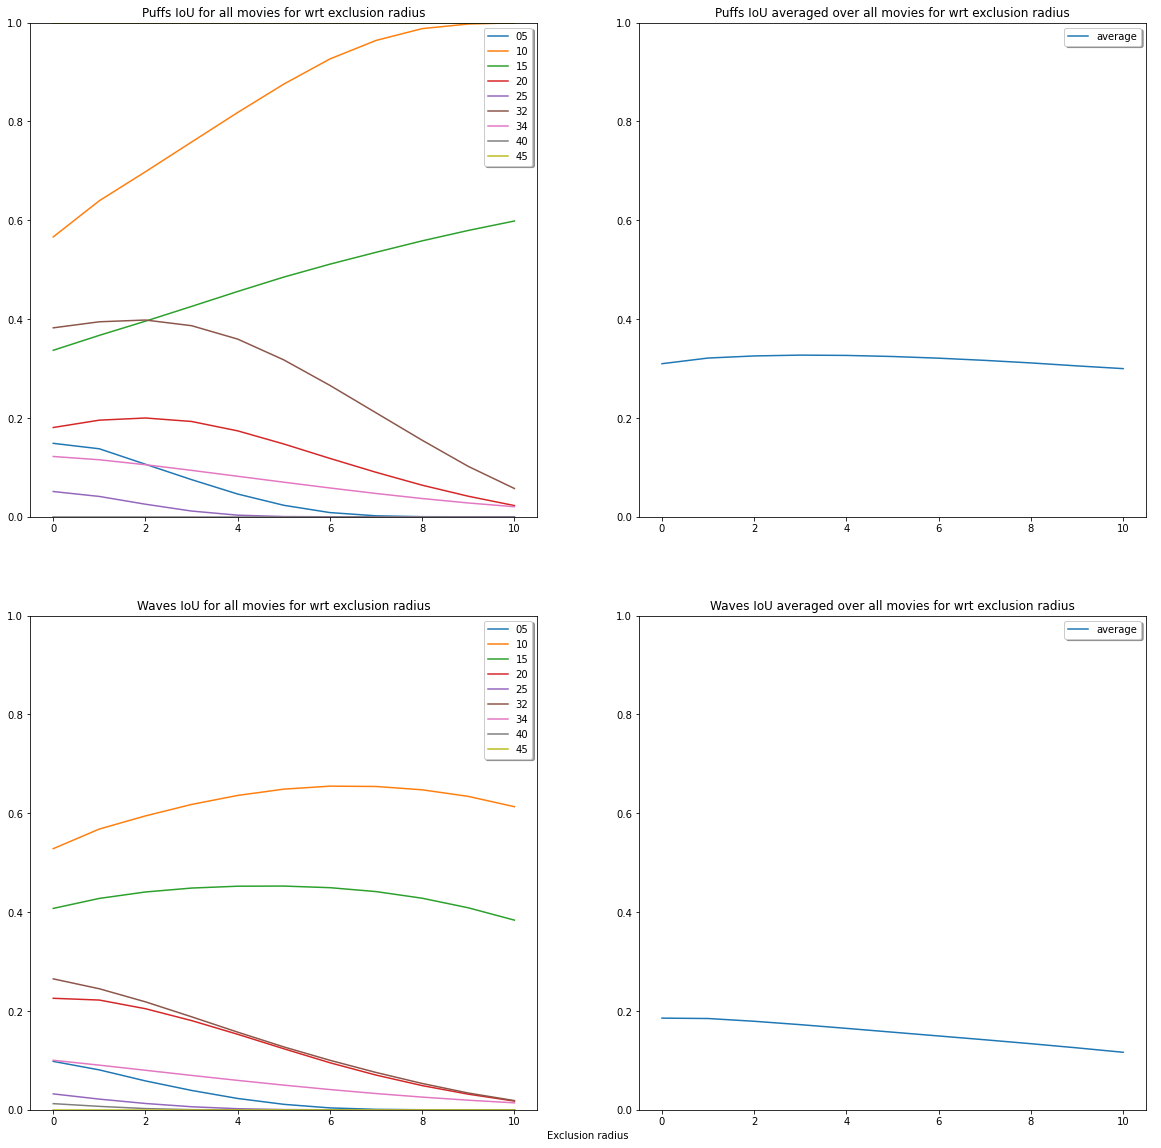

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(20,20))#, sharex=True)
fig.add_subplot(111, frameon=False)

for movie_id in dict_puffs_exclusion_r_plot.keys():
    dict_ious = dict_puffs_exclusion_r_plot[movie_id]
    axs[0,0].plot(dict_ious.keys(), dict_ious.values(), label=movie_id)
           
axs[0,0].set_title('Puffs IoU for all movies for wrt exclusion radius')
axs[0,0].set_ylim([0,1])
axs[0,0].legend(shadow=True, fancybox=True)

axs[0,1].plot(dict_puffs_exclusion_r_average_plot.keys(), dict_puffs_exclusion_r_average_plot.values(), label="average")

axs[0,1].set_title('Puffs IoU averaged over all movies for wrt exclusion radius')
axs[0,1].set_ylim([0,1])
axs[0,1].legend(shadow=True, fancybox=True)

for movie_id in dict_waves_exclusion_r_plot.keys():
    dict_ious = dict_waves_exclusion_r_plot[movie_id]
    axs[1,0].plot(dict_ious.keys(), dict_ious.values(), label=movie_id)
           
axs[1,0].set_title('Waves IoU for all movies for wrt exclusion radius')
axs[1,0].set_ylim([0,1])
axs[1,0].legend(shadow=True, fancybox=True)

axs[1,1].plot(dict_waves_exclusion_r_average_plot.keys(), dict_waves_exclusion_r_average_plot.values(), label="average")

axs[1,1].set_title('Waves IoU averaged over all movies for wrt exclusion radius')
axs[1,1].set_ylim([0,1])
axs[1,1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

fig.savefig(os.path.join(data_folder,"IoU_all_movies_excl_radius.jpg"))

In [16]:
''' OLD VERSION
cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Sparks', 'Puffs', 'Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_sparks_avg.values(),
        *ious_puffs_avg.values(),
        *ious_waves_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

display(df)

df.to_csv("average_IoU_all_trainings_excl_radius.csv")

fig, axs = plt.subplots(1, 3, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(exclusion_radius_list, ious_sparks_avg[training_name], label=training_name)
           
axs[0].set_title('Sparks IoU')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(exclusion_radius_list, ious_puffs_avg[training_name], label=training_name)

axs[1].set_title('Puffs IoU')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[2].plot(exclusion_radius_list, ious_waves_avg[training_name], label=training_name)

axs[2].set_title('Waves IoU')
axs[2].set_ylim([0,1])
axs[2].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

fig.savefig("average_IoU_all_trainings_excl_radius.png")''';

## Compute joined IoU metric for different classes of events

### Join puffs and waves
Idea: sum raw preds of puffs and waves and compute IoU wrt to sum of puffs and waves annotations.

In [111]:
from metrics_tools import compute_average_puff_wave_metrics
# parameters
ignore_frames = 6

# for focal_loss_gamma_5_ubelix

# puffs and waves params
t_detection = [0.5,0.6,0.7,0.8,0.8]#[0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
min_radius = [0,2,4,6,8]#[0,1,2,3,4,5,6,7,8,9,10]

exclusion_radius = [0,1,2,3,4,5,6,7,8,9,10]

ious_sum_all_models = {} # training_name x ...
ious_sum_average_all_models = {} # training_name x ...

for training_name in training_names:
    print(training_name)
    # get predictions
    puffs_training = puffs[training_name]
    waves_training = waves[training_name]
    
    # init empty dictionaires
    ious_sum = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
            
    for video_id in ys_all_trainings.keys():
        print("video id:", video_id)
        ys_sample = ys_all_trainings[video_id]
        puffs_sample = puffs_training[video_id]
        waves_sample = waves_training[video_id]
        
        # sum puff and wave preds
        preds_sum_sample = puffs_sample + waves_sample
        
        # get binary ys and remove ignored frames
        ys_puffs_sample = empty_marginal_frames(np.where(ys_sample==3,1,0), ignore_frames)
        ys_waves_sample = empty_marginal_frames(np.where(ys_sample==2,1,0), ignore_frames)
        ys_sum_sample = np.logical_or(ys_puffs_sample, ys_waves_sample)
        
        # get ignore mask (events labelled with 4)
        ignore_mask = empty_marginal_frames(np.where(ys_sample==4,1,0), ignore_frames)
        
        for t in t_detection:
            #print("t_detection:",t)
            for min_r in min_radius:
                #print("min_radius:",min_r)
                # get binary mask
                preds_sum_binary = process_puff_prediction(preds_sum_sample,
                                                           t,
                                                           min_r,
                                                           ignore_frames)
    
                # compute IoU for some exclusion radius values
                for exclusion_r in exclusion_radius:
                    #print("exclusion_radius:",exclusion_r)
                    #print("exclusion radius:", radius)
                    ious_sum[t][min_r][exclusion_r][video_id] = compute_puff_wave_metrics(ys_sum_sample,
                                                                                          preds_sum_binary,
                                                                                          exclusion_r,
                                                                                          ignore_mask)
    ious_sum_all_models[training_name] = ious_sum
            
    # compute average over movies
    ious_sum_average = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
    for t in t_detection:
            for min_r in min_radius:
                for exclusion_r in exclusion_radius:
                    ious_sum_all_movies = ious_sum_all_models[training_name][t][min_r][exclusion_r]
                    ious_sum_average[t][min_r][exclusion_r] = compute_average_puff_wave_metrics(ious_sum_all_movies)

    ious_sum_average_all_models[training_name] = ious_sum_average

focal_loss_gamma_5_ubelix
video id: 05
video id: 10
video id: 15
video id: 20
video id: 25
video id: 32
video id: 34
video id: 40
video id: 45


In [107]:
'''with open(os.path.join(data_folder,"ious_joined_puffs_waves.json"),"w") as f:
    json.dump(ious_puffs_waves_all_models[training_name],f)

# save average ious dictionaires on disk as json
with open(os.path.join(data_folder,"ious_joined_puffs_waves_average.json"),"w") as f:
    json.dump(ious_puffs_waves_average_all_models[training_name],f)''';

### Plot results for a selected training

In [120]:
training_name = "focal_loss_gamma_5_ubelix"

In [112]:
ious_sum_average_all_models[training_name]

defaultdict(<function __main__.<lambda>()>,
            {0.5: defaultdict(<function __main__.<lambda>.<locals>.<lambda>()>,
                         {0: defaultdict(dict,
                                      {0: {'iou': 0.30818333635746775,
                                        'prec': 0.34546162306863476,
                                        'rec': 0.839799609160655,
                                        'accuracy': 0.9650406923163793},
                                       1: {'iou': 0.304422930066976,
                                        'prec': 0.3359531409194253,
                                        'rec': 0.8590687180143197,
                                        'accuracy': 0.9676826224581971},
                                       2: {'iou': 0.2986302522668567,
                                        'prec': 0.3256157700911979,
                                        'rec': 0.8715622646065496,
                                        'accuracy': 0.96987846080216

In [ ]:
all_metrics_dict = ious_sum_average_all_models[training_name]

for t, min_r_metrics in all_metrics_dict.items():
    for min_r, exclusion_r_metrics in min_r_metrics.items():
        

In [ ]:
# get dict for each metric
all_metrics_dict = ious_sum_average_all_models[training_name]

iou_dict = 

In [127]:
# reverse dictionaires
dict_puffs_waves_exclusion_r_plot = ious_puffs_waves_all_models[training_name]
res = defaultdict(lambda: defaultdict(dict))
for exclusion_r, movies_iou in dict_puffs_waves_exclusion_r_plot.items():
    for movie_name, iou in movies_iou.items():
        res[movie_name][exclusion_r] = iou
dict_puffs_waves_exclusion_r_plot = res # video name x exclusion r
df_puff_wave_all_movies = pd.DataFrame.from_dict(dict_puffs_waves_exclusion_r_plot)

dict_puffs_waves_average_exclusion_r_plot = ious_puffs_waves_average_all_models[training_name]
df_puff_wave_average = pd.DataFrame.from_dict([dict_puffs_waves_average_exclusion_r_plot])

In [126]:
print("all movies")
display(df_puff_wave_all_movies)
print("average")
display(df_puff_wave_average)

all movies


,05,10,15,20,25,32,34,40,45
0,0.147204,0.566367,0.334205,0.181720,0.027498,0.386957,0.513308,0.329887,0.423087
1,0.136237,0.639602,0.363922,0.196234,0.021057,0.400258,0.547260,0.416508,0.411579
2,0.104924,0.698254,0.392500,0.200730,0.013143,0.404944,0.579375,0.433870,0.399832
3,0.074028,0.758333,0.422566,0.193805,0.006224,0.394571,0.609860,0.448030,0.387755
4,0.045079,0.818170,0.453660,0.174842,0.001868,0.368269,0.638501,0.459531,0.375375
5,0.022758,0.875573,0.484067,0.148277,0.000184,0.326433,0.666280,0.468746,0.362635
6,0.008516,0.926489,0.511099,0.118999,0.000000,0.274377,0.692541,0.476195,0.349456
7,0.002030,0.963926,0.535205,0.090746,0.000000,0.217920,0.717531,0.482293,0.335771
8,0.000187,0.987822,0.558356,0.064496,0.000000,0.160951,0.740690,0.487062,0.321490
9,0.000000,0.997135,0.579414,0.041998,0.000000,0.106298,0.761715,0.490796,0.306542


average


,0,1,2,3,4,5,6,7,8,9,10
0,0.323359,0.348073,0.358619,0.36613,0.370588,0.372773,0.373075,0.371714,0.369006,0.364878,0.360546


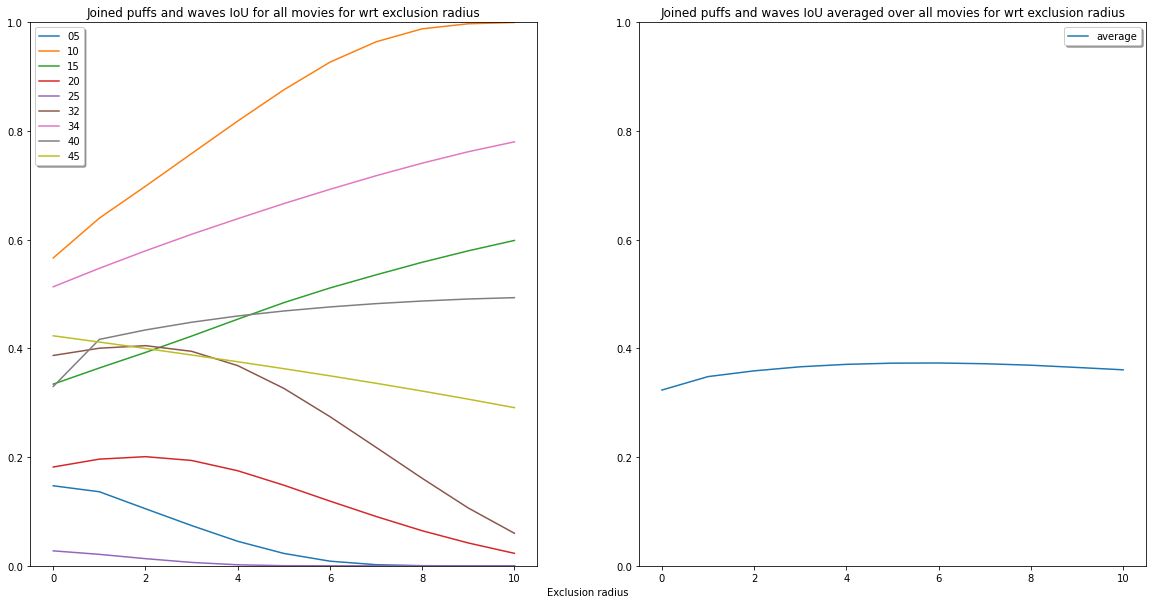

In [205]:
fig, axs = plt.subplots(1, 2, figsize=(20,10))#, sharex=True)
fig.add_subplot(111, frameon=False)

for movie_id in dict_puffs_waves_exclusion_r_plot.keys():
    dict_ious = dict_puffs_waves_exclusion_r_plot[movie_id]
    axs[0].plot(dict_ious.keys(), dict_ious.values(), label=movie_id)
           
axs[0].set_title('Joined puffs and waves IoU for all movies for wrt exclusion radius')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

axs[1].plot(dict_puffs_waves_average_exclusion_r_plot.keys(), dict_puffs_waves_average_exclusion_r_plot.values(), label="average")

axs[1].set_title('Joined puffs and waves IoU averaged over all movies for wrt exclusion radius')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

fig.savefig(os.path.join(data_folder,"IoU_joined_puffs_waves_excl_radius.jpg"))

In [24]:
''' OLD PLOT VERSION
### Plot average IoU for all trainings and all classes wrt to exclusion radius

cols = pd.Index(exclusion_radius_list, name='Exclusion radius')
classes = ['Puffs and Waves']
rows = pd.MultiIndex.from_product([classes, training_names], names=['Class', 'Training name'])

data = [*ious_puffs_waves_average_all_models.values()
       ]

df = pd.DataFrame(data, rows, cols)

display(df)

df.to_csv("average_IoU_all_trainings_excl_radius_puffs_waves.csv")

fig, axs = plt.subplots(1, 1, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs.plot(ious_puffs_waves_average_all_models[training_name].keys(), ious_puffs_waves_average_all_models[training_name].values(), label=training_name)
           
axs.set_title('Joined Puffs and Waves IoU')
axs.set_ylim([0,1])
axs.legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Exclusion radius")

fig.savefig("average_IoU_all_trainings_excl_radius_puffs_waves.png")'''

## Compute puffs IoU using convex hull

Idea: calcolo la convex hull di tutti i predicted puffs e poi calcolo l'IoU per vedere se migliora (in teoria ignora gli sparks on top of puffs).

In [194]:
# training parameters
training_name = "focal_loss_gamma_5_ubelix"
ignore_frames = 6

# detection parameters
t_detection_puffs = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
min_radius_puffs = [0,1,2,3,4,5,6]

In [195]:
puffs_ious = defaultdict(lambda: defaultdict(dict))
puffs_ious_all_movies = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for movie_name in ys_all_trainings.keys():
    # get puff binary annotations
    puffs_ys = ys[training_name][movie_name]
    puffs_ys = np.where(puffs_ys == 3, 1, 0)
    puffs_ys = empty_marginal_frames(puffs_ys, ignore_frames)

    # get ignore mask
    raw_ys = ys_all_trainings[movie_name]
    ignore_mask =  np.where(raw_ys==4,1,0)

    # get binary puff prediction
    puffs_pred = puffs[training_name][movie_name]
    
    for t in t_detection_puffs:
        for r in min_radius_puffs:
            # remove holes (convex hull) & small events from puffs
            puffs_pred_processed = process_puff_prediction(pred=puffs_pred,
                                                 t_detection=t,
                                                 min_radius=r,
                                                 ignore_frames=ignore_frames,
                                                 convex_hull=True # <-- difference
                                                )

            # compute IoU
            puffs_ious_all_movies[t][r][movie_name] = jaccard_score_exclusion_zone(ys=puffs_ys,
                                                                       preds=puffs_pred_processed,
                                                                       exclusion_radius=0,
                                                                       ignore_mask=ignore_mask)
        
# compute average over movies
for t in t_detection_puffs:
    for r in min_radius_puffs:
        puffs_ious[t][r] = sum(puffs_ious_all_movies[t][r].values()) / len(puffs_ious_all_movies[t][r])


In [196]:
# save ious dictionaires on disk as json
data_folder = os.path.join(metrics_folder, training_name, "puff_wave_ious")
os.makedirs(data_folder, exist_ok=True)

with open(os.path.join(data_folder,"ious_puffs_no_holes.json"),"w") as f:
    json.dump(puffs_ious_all_movies,f)

# save average ious dictionaires on disk as json
with open(os.path.join(data_folder,"ious_puffs_no_holes_average.json"),"w") as f:
    json.dump(puffs_ious,f)

Same but without removing holes

In [197]:
puffs_ious_holes = defaultdict(lambda: defaultdict(dict))
puffs_ious_all_movies_holes = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for t in t_detection_puffs:
    for r in min_radius_puffs:
        for movie_name in ys_all_trainings.keys():
            # get puff binary annotations
            puffs_ys = ys[training_name][movie_name]
            puffs_ys = np.where(puffs_ys == 3, 1, 0)
            puffs_ys = empty_marginal_frames(puffs_ys, ignore_frames)
            
            # get ignore mask
            raw_ys = ys_all_trainings[movie_name]
            ignore_mask =  np.where(raw_ys==4,1,0)
            
            # get binary puff prediction
            puffs_pred = puffs[training_name][movie_name]

            # remove holes (convex hull) & small events from puffs
            puffs_pred = process_puff_prediction(pred=puffs_pred,
                                                 t_detection=t,
                                                 min_radius=r,
                                                 ignore_frames=ignore_frames,
                                                 convex_hull=False # <-- difference
                                                )

            # compute IoU
            puffs_ious_all_movies_holes[t][r][movie_name] = jaccard_score_exclusion_zone(ys=puffs_ys,
                                                                       preds=puffs_pred,
                                                                       exclusion_radius=0,
                                                                       ignore_mask=ignore_mask)
        
        # compute average over movies
        puffs_ious_holes[t][r] = sum(puffs_ious_all_movies_holes[t][r].values()) / len(puffs_ious_all_movies_holes[t][r])

### Visualize results using confusion matrices

In [198]:
import pandas as pd
import seaborn as sns
#import matplotlib.pyplot as plt

In [199]:
df = pd.DataFrame.from_dict(puffs_ious)
df_holes = pd.DataFrame.from_dict(puffs_ious_holes)

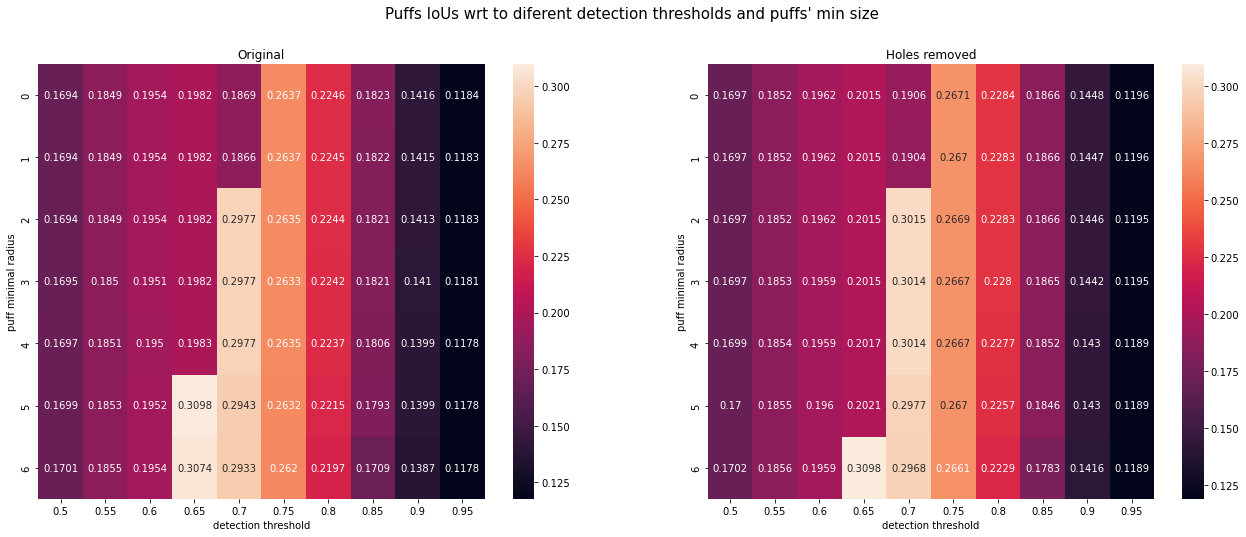

In [204]:
plt.figure(figsize=(22,8))
plt.suptitle(f"Puffs IoUs wrt to diferent detection thresholds and puffs' min size", fontsize=15)

ax = plt.subplot(1,2,1)
ax.set_title("Original")
sns.heatmap(df_holes, annot=True, fmt='.4g')
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
ax = plt.subplot(1,2,2)
ax.set_title("Holes removed")
sns.heatmap(df, annot=True, fmt='.4g')
ax.set_xlabel("detection threshold")
ax.set_ylabel("puff minimal radius")
plt.savefig(os.path.join(data_folder,"confusion_matrix_IoU_puff_holes_vs_no_holes.jpg"))
plt.show()

## Separate events in puffs and waves predictions

Pipeline:

- get puffs and waves predictions
    - extract events using `separate_events`
- get puffs and waves annotations **with separate events** (from new data folder)
    - transform movie from 3 colors to 1 color
    - extract puffs and sparks comparing with {0,1,2,3,4}-annotations
- get ignore mask
- for each event (in puffs/waves/joined)
    - find event with max overlap in annotations
    - if overlap > t => true positive
    - otherwise => false positive
    - store which preds are coupled with which annotations
    - if there is an annotation with no paired event => false negative

In [25]:
from dataset_tools import load_movies_ids

In [165]:
# training params
training_name = "focal_loss_gamma_5_ubelix"
ignore_frames = 6

# puffs and waves params
t_detection = 0.7
min_radius_puffs = 6
min_radius_waves = 8

In [173]:
data_folder = os.path.join(metrics_folder, training_name, "separated_events")
os.makedirs(data_folder, exist_ok=True)

In [32]:
# load all annotations with separated events (!they aren't classified!)
separated_annnotations_path = os.path.join("..","data","raw_data_and_processing","original_separated_events_masks")
movie_names = ys_all_trainings.keys()

separated_annotations = load_movies_ids(data_folder=separated_annnotations_path, ids=movie_names)

TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'
TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


In [166]:
movie_name = '05'

In [167]:
# get puff and wave annotation masks
ys_sample = ys[training_name][movie_name]
puff_ys = np.where(ys_sample == 3, 1., 0.)
wave_ys = np.where(ys_sample == 2, 1., 0.)

# get puff and wave annotations with separate events
ys_rgb = np.array(separated_annotations[movie_name], dtype=np.int32)

# transform RGB to integer by 255*255*r + 255*g + b and set white to 0
ys_events = 255*255*ys_rgb[...,0] + 255*ys_rgb[...,1] + ys_rgb[...,2]
white_int = 255*255*255+255*255+255
ys_events[ys_events == white_int] = 0

# get separated annotated puff and wave events
puff_ys_events = np.where(puff_ys, ys_separated_events, 0)
puff_ys_events = empty_marginal_frames(puff_ys_events, ignore_frames)

wave_ys_events = np.where(wave_ys, ys_separated_events, 0)
wave_ys_events = empty_marginal_frames(wave_ys_events, ignore_frames)

In [168]:
# get puff and wave predictions
puff_preds = puffs[training_name][movie_name]
wave_preds = waves[training_name][movie_name]

# get binary predicted puff and wave events
puff_pred_binary = process_puff_prediction(pred=puff_preds,
                                           t_detection=t_detection,
                                           min_radius=min_radius_puffs,
                                           ignore_frames=ignore_frames,
                                           convex_hull=True
                                          )
wave_pred_binary = process_wave_prediction(pred=wave_preds,
                                           t_detection=t_detection,
                                           min_radius=min_radius_waves,
                                           ignore_frames=ignore_frames
                                          )

In [169]:
import cc3d

In [170]:
# identify events in puff and wave preds
connectivity = 26
puff_labels, puff_n_events = cc3d.connected_components(puff_pred_binary, 
                                                       connectivity=connectivity,
                                                       return_N=True
                                                      )

In [172]:
puff_n_events

15

In [ ]:
imageio.volwrite(os.path.join(data_folder, movie_name+"_separated_events.tif"), puff_labels)

# Sparks metrics (TODO)

In [20]:
from metrics_tools import compute_prec_rec, reduce_metrics_thresholds

In [21]:
# physiological params
PIXEL_SIZE = 0.2 # 1 pixel = 0.2 um x 0.2 um
MIN_DIST_XY = round(1.8 / PIXEL_SIZE) # min distance in space between sparks
TIME_FRAME = 6.8 # 1 frame = 6.8 ms
MIN_DIST_T = round(20 / TIME_FRAME) # min distance in time between sparks

# parameters
ignore_frames = 6

## Plain precision and recall

In [32]:
from metrics_tools import compute_prec_rec

In [42]:
# parameters
ignore_frames = 6

t_detection_sparks = [0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]
min_radius_sparks = [0]#,1,2]

prec_rec_sparks_all_trainings = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))
prec_rec_sparks_avg = defaultdict(lambda: defaultdict(dict))

for training_name in training_names:
    print(training_name)
    for movie_name in ['05']:#ys_all_trainings.keys():
        print(movie_name)
        sparks_sample = sparks[training_name][movie_name]
        ys_sample = ys[training_name][movie_name]
        ys_raw = ys_all_trainings[movie_name]
        # NEW
        movie = movies[video_id] 
        
        # get binary ys 
        ys_sparks_sample = np.where(ys_sample==1,1.0,0.0)
        
        # get ignore mask
        ignore_mask =  np.where(ys_raw==4,1,0)
            
        for min_r in min_radius_sparks:
            # compute precision and recall for some thresholds and remove ignored frames
            prec_rec_all_t = compute_prec_rec(annotations=ys_sparks_sample,
                                              preds=sparks_sample,
                                              movie=movie,
                                              thresholds=t_detection_sparks,
                                              ignore_frames=ignore_frames,
                                              min_radius=min_r,
                                              min_dist_xy=MIN_DIST_XY,
                                              min_dist_t=MIN_DIST_T,
                                              ignore_mask=ignore_mask
                                             ) # dict indexed by threshold value
            prec_rec_sparks_all_trainings[training_name][min_r][movie_name] = prec_rec_all_t
            
    # compute average
    for min_r in min_radius_sparks:
        prec_rec_all_videos = prec_rec_sparks_all_trainings[training_name][min_r]
        prec_rec_sparks_avg[training_name][min_r] = reduce_metrics_thresholds(prec_rec_all_videos)

focal_loss_gamma_5_ubelix
05


In [46]:
np.linspace(0,1,21)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

### Dataframe and plots of results

In [ ]:
cols = pd.Index(t_detection_sparks, name='Detection threshold')
metrics = ['Precision', 'Recall']
rows = pd.MultiIndex.from_product([metrics, training_names], names=['Class', 'Training name'])

data = [*prec_avg.values(),
        *rec_avg.values()
       ]

df = pd.DataFrame(data, rows, cols)

In [ ]:
display(df)

,Detection threshold,0.5
Class,Training name,
Precision,focal_loss_gamma_5_ubelix,0.261307
Recall,focal_loss_gamma_5_ubelix,0.742857


In [220]:
df.to_csv("sparks_precision_recall.csv")

Text(0.5, 0, 'Detection threshold')

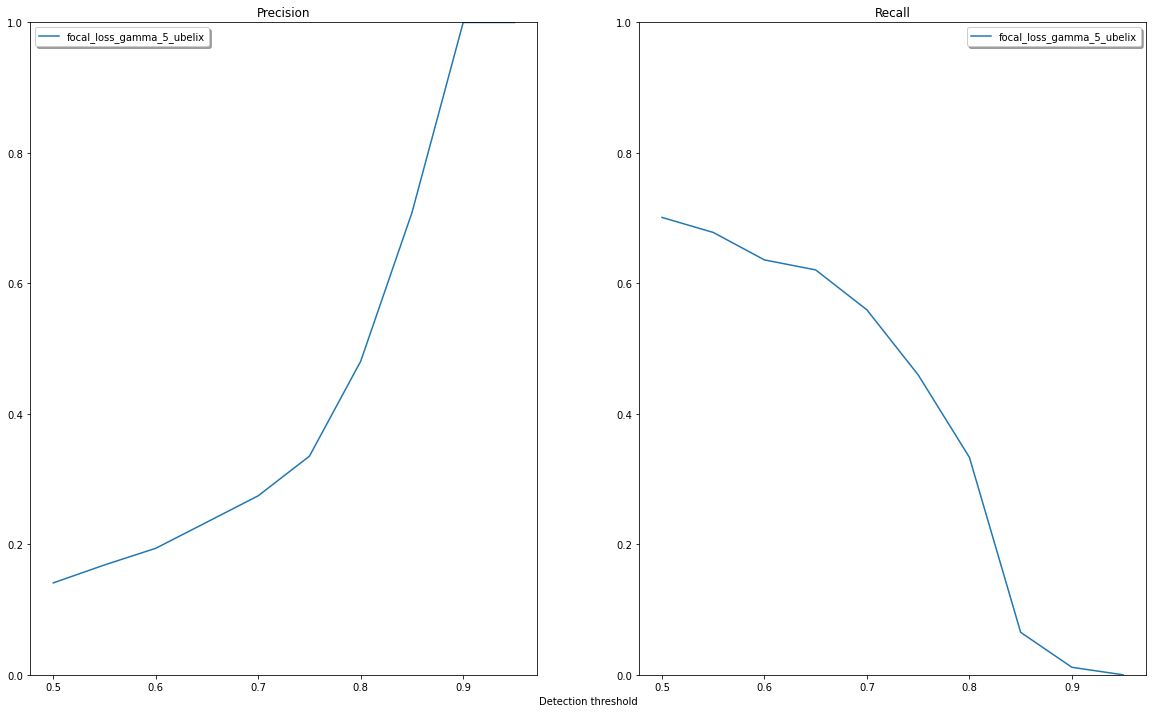

In [221]:
fig, axs = plt.subplots(1, 2, sharex=True, figsize=(20,12))
fig.add_subplot(111, frameon=False)

for training_name in training_names:
    axs[0].plot(t_detection_sparks, prec_avg[training_name].values(), label=training_name)
           
axs[0].set_title('Precision')
axs[0].set_ylim([0,1])
axs[0].legend(shadow=True, fancybox=True)

for training_name in training_names:
    axs[1].plot(t_detection_sparks, rec_avg[training_name].values(), label=training_name)

axs[1].set_title('Recall')
axs[1].set_ylim([0,1])
axs[1].legend(shadow=True, fancybox=True)

plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Detection threshold")

In [23]:
fig.savefig("sparks_precision_recall.png")

## Set lower threshold for sparks inside puffs

Idee : 

- rendere i puffs convessi e controllare se lo spark interseca il puff
- sommare la probabilità di puff e sparks se e.g. puff > 0 e sparks > 0.7 <-- provo prima con questa possibilità perché non sempre gli sparks sono all'interno dei puffs

### Sum puff probabilities to sparks (just for one training)

In [25]:
training_name = "focal_loss_gamma_5_ubelix"

ignore_frames = 6

t_puffs_lower = 0.3
t_puffs_upper = [0.0,0.5,0.55,0.6,0.65] # = t detection puffs (0 for standard detection) (t included)

t_detection_sparks = [0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95] # for sum of puffs and sparks (t not included)

min_radius_sparks = [0,1,2] # da vedere come usarlo

In [39]:
from metrics_tools import compute_prec_rec, reduce_metrics_thresholds

In [40]:
prec_rec_auc = defaultdict(lambda: defaultdict(dict))
prec_rec_auc_all_movies = defaultdict(lambda: defaultdict(lambda: defaultdict(dict)))

for min_r in min_radius_sparks:
    print(f"sparks' min radius: {min_r}")
    for t_p in t_puffs_upper:
        print(f"puffs' upper threshold: {t_p}")
        for movie_name in ys_all_trainings.keys():
            print(f"movie's name: {movie_name}")
            # open spark preds :
            sparks_pred = sparks[training_name][movie_name]
            # open puff preds :
            puffs_pred = puffs[training_name][movie_name]
            
            # process spark & puff preds together :
            # compute region where 0.3 <= puffs <= 0.65
            binary_puffs_sparks = np.logical_and(puffs_pred <= t_p, puffs_pred >= t_puffs_lower)
            # sum value of sparks and puffs in this region
            sparks_pred_total = sparks_pred + binary_puffs_sparks * puffs_pred
            
            # get binary annotation mask
            ys_sparks = ys[training_name][movie_name]
            binary_ys_sparks = np.where(ys_sparks==1,1.0,0.0)
            
            # get ignore mask
            ys_raw = ys_all_trainings[movie_name]
            ignore_mask =  np.where(ys_raw==4,1,0)
            
            # compute prec & rec for all t_detection_sparks
            prec_rec_all_t, auc = compute_prec_rec(annotations=binary_ys_sparks,
                                                   preds=sparks_pred_total,
                                                   thresholds=t_detection_sparks,
                                                   ignore_frames=ignore_frames,
                                                   min_radius=min_r,
                                                   min_dist_xy=MIN_DIST_XY,
                                                   min_dist_t=MIN_DIST_T,
                                                   ignore_mask=ignore_mask
                                                  ) # dict indexed by threshold value
            #print(f"precision and recall for all t_detection_sparks: {prec_rec_all_t}")
            
            # get dict of Metrics for each min_r, t_p, movie_name
            prec_rec_auc_all_movies[min_r][t_p][movie_name] = (prec_rec_all_t, auc)            
            
        # get only prec & rec metrics for all movies
        metrics_dict = {movie_name: metrics[0] for (movie_name, metrics) in prec_rec_auc_all_movies[min_r][t_p].items()}
        #pprint.pprint(metrics_dict)
        
        # reduce prec & rec over all movies and compute AUC
        reduced_prec_rec, _, _, reduced_auc = reduce_metrics_thresholds(metrics_dict)
        #pprint.pprint(reduced_prec_rec)
        #print(reduced_auc)
        prec_rec_auc[min_r][t_p] = (reduced_prec_rec, reduced_auc)

# obtain dicts s.t. 
#prec_rec_auc[min_r][t_p] = (reduced metrics, reduced AUC)
#prec_rec_auc_all_movies[min_r][t_p][movie_name] = (movie_name's metrics, movie_name's AUC)

sparks' min radius: 0
puffs' upper threshold: 0.0
movie's name: 05
movie's name: 10
movie's name: 15
movie's name: 20
movie's name: 25
movie's name: 32
movie's name: 34
movie's name: 40
movie's name: 45
puffs' upper threshold: 0.5
movie's name: 05


ValueError: x is neither increasing nor decreasing : [0.71428571 0.72857143 0.62857143 0.51428571 0.41428571 0.34285714
 0.2       ].

In [ ]:
pprint.pprint(prec_rec_auc_all_movies)

#### Average over all movies 

In [ ]:
'''ious_sparks_avg = {} # num training x num exclusion radius
ious_puffs_avg = {}
ious_waves_avg = {}

for training_name in training_names:
    num_videos = len(ious_sparks_all_trainings[training_name])
    
    ious_sparks_all_video = ious_sparks_all_trainings[training_name] # num videos x num exclusion radius
    ious_puffs_all_video = ious_puffs_all_trainings[training_name] 
    ious_waves_all_video = ious_waves_all_trainings[training_name]
    
    ious_sparks_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_sparks_all_video.values()]),0)/num_videos
    ious_puffs_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_puffs_all_video.values()]),0)/num_videos
    ious_waves_avg[training_name] = np.sum(np.array([list(res.values()) for res in ious_waves_all_video.values()]),0)/num_videos''';

In [14]:
from metrics_tools import reduce_metrics_thresholds

In [15]:
# reverse dictionaires
res = defaultdict(lambda: defaultdict(dict)) # t_upper x min_radius x num movies x t
for movie_name, prec_rec in all_movies_prec_rec.items():
    for t_upper, t_upper_prec_rec in prec_rec.items():
        for min_radius, min_r_prec_rec in t_upper_prec_rec.items():
            res[t_upper][min_radius][movie_name] = min_r_prec_rec

In [74]:
# compute average over movies
avg_prec_rec = defaultdict(lambda: defaultdict(dict))
for t_upper, t_upper_prec_rec in res.items():
    for min_radius, min_r_prec_rec in t_upper_prec_rec.items():
        # get Metrics object and transform it to dict
        metrics = reduce_metrics_thresholds(min_r_prec_rec)[0]
        metrics = metrics[list(metrics)[0]]._asdict()
        #print(metrics)
        for metric in Metrics._fields:
            #print(metric)
            #print(metrics[metric])
            avg_prec_rec[metric][t_upper][min_radius] = metrics[metric]

### Results visualization

In [134]:
for k,v in avg_prec_rec.items():
    print(k,v)

precision defaultdict(<class 'dict'>, {0.0: {0: 0.21079691516709512, 1: 0.22869318181818182, 2: 0.2744360902255639}, 0.5: {0: 0.18319838056680163, 1: 0.20135746606334842, 2: 0.24287856071964017}, 0.55: {0: 0.17829457364341086, 1: 0.19271948608137046, 2: 0.23470839260312945}, 0.6: {0: 0.17481203007518797, 1: 0.19047619047619047, 2: 0.2269021739130435}, 0.65: {0: 0.17088607594936708, 1: 0.18514851485148515, 2: 0.2198952879581152}})
recall defaultdict(<class 'dict'>, {0.0: {0: 0.6283524904214559, 1: 0.6168582375478927, 2: 0.5593869731800766}, 0.5: {0: 0.6934865900383141, 1: 0.6819923371647509, 2: 0.6206896551724138}, 0.55: {0: 0.7049808429118773, 1: 0.6896551724137931, 2: 0.632183908045977}, 0.6: {0: 0.7126436781609196, 1: 0.7049808429118773, 2: 0.6398467432950191}, 0.65: {0: 0.7241379310344828, 1: 0.7164750957854407, 2: 0.6436781609195402}})
tp defaultdict(<class 'dict'>, {0.0: {0: 164, 1: 161, 2: 146}, 0.5: {0: 181, 1: 178, 2: 162}, 0.55: {0: 184, 1: 180, 2: 165}, 0.6: {0: 186, 1: 184, 

In [136]:
# create a dict of dataframes over metric type
df_dict = {k: pd.DataFrame(v) for k, v in avg_prec_rec.items()}

In [120]:
df_simple = pd.concat({k: pd.DataFrame(v) for k, v in avg_prec_rec.items()})

In [119]:
cols = pd.Index(t_puffs_upper, name='Puffs upper bounds')
classes = Metrics._fields
rows = pd.MultiIndex.from_product([classes, min_radius_sparks], names=['Metrics', 'Sparks min size'])

#data = [*ious_sparks_avg.values(),
#       *ious_puffs_avg.values(),
#       *ious_waves_avg.values()
#      ]

#pprint.pprint(list(dict(avg_prec_rec).values()))

#data = [[list(radius_dict.values())]  for metric_dict in avg_prec_rec.values() 
#        for radius_dict in list(dict(metric_dict).values())
#       ]

data = [metric_res for metric_dict in avg_prec_rec.values() for metric_res in metric_dict]

print("num t_upper", len(t_puffs_upper))
print("num min size", len(min_radius_sparks))
print("num metrics", len(Metrics._fields))
pprint.pprint(data)

df = pd.DataFrame(data, rows, cols)

num t_upper 5
num min size 3
num metrics 5
[0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65,
 0.0,
 0.5,
 0.55,
 0.6,
 0.65]


ValueError: Shape of passed values is (25, 1), indices imply (15, 5)

In [116]:
display(df)

,Puffs upper bounds,0.00,0.50,0.55,0.60,0.65
Metrics,Sparks min size,,,,,
precision,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
recall,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
tp,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
tp_fp,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN
tp_fn,focal_loss_gamma_5_ubelix,NaN,NaN,NaN,NaN,NaN


In [137]:
from pandasgui import show
show(*list(df_dict.values()))

PandasGUI INFO — pandasgui.gui — Opening PandasGUI
PandasGUI WARNING — pandasgui.utility — In untitled_1, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_2, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_3, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_4, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
PandasGUI WARNING — pandasgui.utility — In untitled_5, converted column names to string: 0.0, 0.5, 0.55, 0.6, 0.65
